In [69]:
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size = (256,256),
    batch_size = 32,
    shuffle = True
)

Found 2152 files belonging to 3 classes.


In [10]:
#folder names are the class names
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
#every element is a batch of 32 imgages
68*32

2176

In [25]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 1 1 2 0 0 0 1 1 1 2 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0]


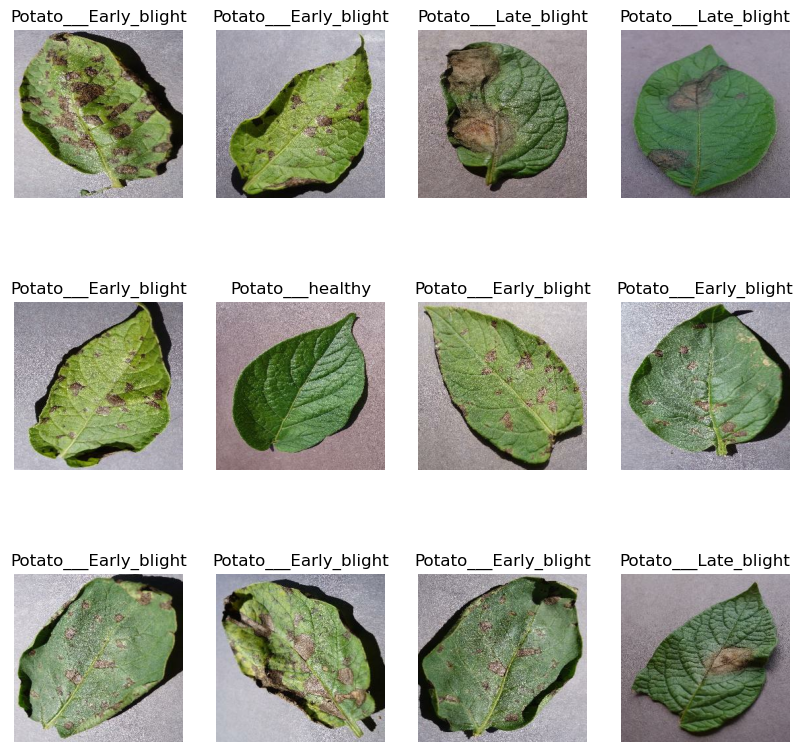

In [39]:
#visualizaiton
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis('off')

In [71]:
#splitting dataset
# 80% >> training
# 20% >> 10% validation + 10% test
# after each epoch we run a validation test using validation dataset. 
# After all the epochs are run, we will test our data on test dataset
epochs = 50
channels = 3

In [59]:
def test_train_val_split(ds,train = 0.8, test = 0.1, validation = 0.1, shuffle = True, shuffle_size = 10000):
    
    if shuffle:
        ds.shuffle(shuffle_size, seed = 12)
    
    ds_size = len(ds)
    train_size = int(train*ds_size)
    val_size = int(validation*ds_size)
    
    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(val_size)
    test_dataset = ds.skip(train_size).skip(val_size)
    
    return train_dataset, test_dataset, val_dataset

In [60]:
 train_dataset, test_dataset, val_dataset = test_train_val_split(dataset)

In [64]:
print(f"Traning dataset length: {len(train_dataset)}, Testing dataset length: {len(test_dataset)}, Validation dataset length: {len(val_dataset)}")

Traning dataset length: 54, Testing dataset length: 8, Validation dataset length: 6


In [65]:
#optimizing tensorflow pipelines
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [70]:
#PreProcessing
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [73]:
#model building
batch_size = 32
image_size = 256
channels = 3
input_shape = (batch_size,image_size,image_size,channels)
n_classes = 3

In [82]:
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     multiple                  0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (32, 60, 60, 64)         

In [86]:
#compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [87]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 37s 632ms/step - loss: 0.9090 - accuracy: 0.5179 - val_loss: 0.8651 - val_accuracy: 0.5156
Epoch 2/50
54/54 [==============================] - 32s 597ms/step - loss: 0.7216 - accuracy: 0.6719 - val_loss: 0.6719 - val_accuracy: 0.6562
Epoch 3/50
54/54 [==============================] - 32s 591ms/step - loss: 0.4921 - accuracy: 0.7975 - val_loss: 0.3458 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 33s 615ms/step - loss: 0.3596 - accuracy: 0.8455 - val_loss: 0.2561 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 33s 614ms/step - loss: 0.2729 - accuracy: 0.8976 - val_loss: 0.3532 - val_accuracy: 0.8438
Epoch 6/50
54/54 [==============================] - 34s 621ms/step - loss: 0.2418 - accuracy: 0.9039 - val_loss: 0.2148 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 34s 632ms/step - loss: 0.1458 - accuracy: 0.9433 - val_loss: 0.0891 - val_accuracy: 0.9635

In [88]:
scores = model.evaluate(test_dataset)
scores

8/8 [==============================] - 3s 231ms/step - loss: 0.0479 - accuracy: 0.9741


[0.04790693148970604, 0.9741379022598267]

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 631ms/step
predicted label: Potato___Late_blight


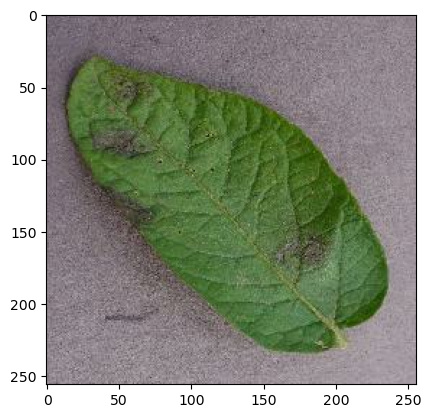

In [90]:
import numpy as np
for images_batch, labels_batch in test_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classes[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [94]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 57ms/step


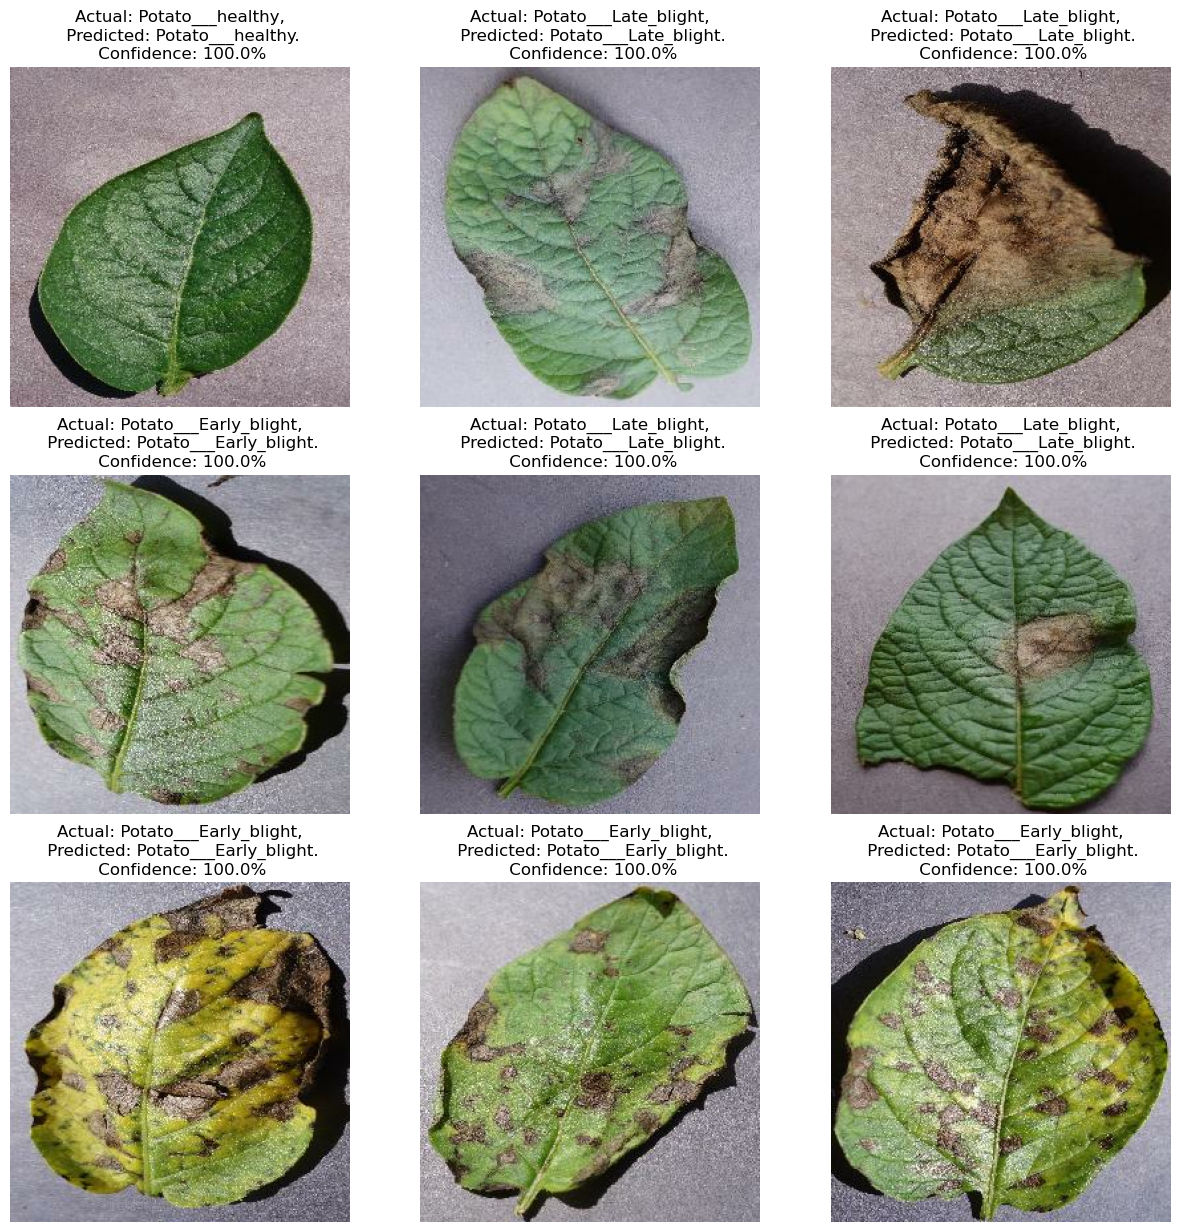

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [99]:
#saving the model

model.save("Predicting model")

INFO:tensorflow:Assets written to: Predicting model\assets


INFO:tensorflow:Assets written to: Predicting model\assets
